<a href="https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/04__Estimator_Flowers_transfer_learning_TFHub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please select a GPU backend for this notebook. It uses pre-trained models from TF Hub which are not TPU-compatible yet

## Imports

In [3]:
import os, math, json
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
print("Tensorflow version " + tf.__version__)
tf.enable_eager_execution()

Tensorflow version 1.13.1


In [0]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  if tf.executing_eagerly():
    # In eager mode, iterate in the Datset directly.
    for images, labels, one_hot_labels in dataset:
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()
      numpy_one_hot_labels = one_hot_labels.numpy()
      break;
      
  else: # In non-eager mode, must get the TF note that 
        # yields the nextitem and run it in a tf.Session.
    get_next_item = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as ses:
      (numpy_images,
       numpy_labels,
       numpy_one_hot_labels) = ses.run(get_next_item)

  return numpy_images, numpy_labels, numpy_one_hot_labels

def title_from_label_and_one_hot(label, one_hot_label):
  return label.decode("utf-8") + ' ' + str(one_hot_label)
def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(label.decode("utf-8"), str(correct), ', shoud be ' if not correct else '',
                              correct_label.decode("utf-8") if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels, one_hot_labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = title_from_label_and_one_hot(labels[i], one_hot_labels[i])
    subplot = display_one_flower(image, title, subplot)
    if subplot > 339:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.array(CLASSES)[np.argmax(predictions, axis=-1)]
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if subplot > 339:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Colab-only auth

In [0]:
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
if IS_COLAB_BACKEND:
  from google.colab import auth
  auth.authenticate_user()  # not necessary to access a public bucket but you will probably want to access your private buckets too
  
HAS_COLAB_TPU = 'COLAB_TPU_ADDR' in os.environ
assert not HAS_COLAB_TPU, "Please select a GPU backend for this notebook. Pre-trained models in TF Hub are not yet TPU-compatible"

## Configuration

In [6]:
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192/*.tfrec'
IMAGE_SIZE = [192, 192]

BATCH_SIZE = 64 # 128 works on GPU too but comes very close to the memory limit of the Colab GPU
EPOCHS = 6

VALIDATION_SPLIT = 0.19
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips'] # do not change, maps to the labels in the data (folder names)

# splitting data files between training and validation
filenames = tf.gfile.Glob(GCS_PATTERN)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 64, there will be 46 batches per training epoch and 10 batch(es) per validation run.


## Read images and labels from TFRecords

In [0]:
def read_tfrecord(example):
    features = {
        "image": tf.FixedLenFeature((), tf.string), # tf.string means byte string
        "label": tf.FixedLenFeature((), tf.string),
        "one_hot_label": tf.FixedLenFeature((), tf.string)
    }
    example = tf.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'])
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    one_hot_label = tf.io.decode_raw(example['one_hot_label'], out_type=tf.uint8) # 'decode' byte string into byte list
    one_hot_label = tf.cast(one_hot_label, tf.float32)  # convert one hot labels to floats
    one_hot_label = tf.reshape(one_hot_label, [5])  # explicit fixed size needed on TPU
    label = example['label']  # byte string
    return image, label, one_hot_label

def load_dataset(filenames):  
  # read from tfrecs
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=32)  # this will read from multiple GCS files in parallel
  dataset = records.map(read_tfrecord, num_parallel_calls=32)
  return dataset

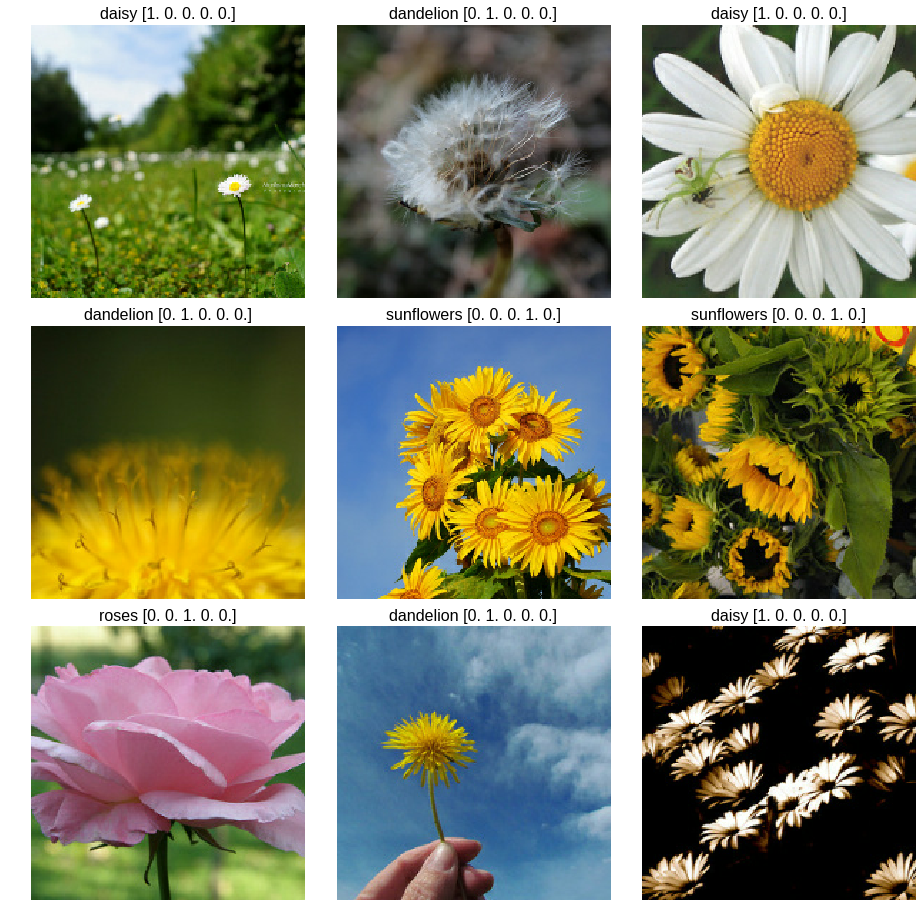

In [9]:
display_9_images_from_dataset(load_dataset(training_filenames))

## training and validation datasets

In [0]:
def features_and_targets(image, label, one_hot_label):
  feature = image
  target = one_hot_label
  return feature, target  # for training, a Keras model needs 2 items: features and targets

def get_batched_dataset(filenames):
  dataset = load_dataset(filenames)
  dataset = dataset.map(features_and_targets, num_parallel_calls=32)
  dataset = dataset.cache() # This dataset fits in RAM
  dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # drop_remainder needed on TPU
  dataset = dataset.prefetch(-1) # prefetch next batch while training (-1: autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset

# input functions
def training_input_fn():
  return get_batched_dataset(training_filenames)
def validation_input_fn():
  return get_batched_dataset(validation_filenames)

## Model

In [0]:
def model_fn(features, labels, mode, params):
  module = hub.Module("https://tfhub.dev/google/imagenet/mobilenet_v2_050_192/feature_vector/2")
  #module = hub.Module("https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/1")
  
  transformed_features = module(features)
  logits = tf.layers.dense(transformed_features, 5)
  probabilities = tf.nn.softmax(logits)
  
  if (mode != tf.estimator.ModeKeys.PREDICT):
    loss = tf.losses.softmax_cross_entropy(labels, logits)
    optimizer = tf.train.AdamOptimizer() 
    train_op = tf.contrib.training.create_train_op(loss, optimizer)
    accuracy = tf.metrics.accuracy(tf.argmax(labels, axis=-1), tf.argmax(probabilities, axis=-1))
    metrics = {'acc':accuracy}
  else:
    # None of these can be computed in prediction mode because labels are not available
    loss = optimizer = train_op = metrics = None
  
  return tf.estimator.EstimatorSpec(
      mode=mode,
      loss=loss,
      train_op=train_op,
      # Nice: in estimator, you can return computed results that are not part of model training (here: class)
      predictions={'proba': probabilities, 'class': tf.argmax(probabilities, axis=-1)},
      eval_metric_ops=metrics
  )

In [0]:
!rm -rf ./model_dir

In [13]:
training_config = tf.estimator.RunConfig(model_dir="./model_dir", save_summary_steps=5, save_checkpoints_steps=steps_per_epoch, log_step_count_steps=5)
estimator = tf.estimator.Estimator(model_fn=model_fn, config=training_config)
train_spec = tf.estimator.TrainSpec(training_input_fn, max_steps=EPOCHS*steps_per_epoch)
eval_spec = tf.estimator.EvalSpec(validation_input_fn, steps=validation_steps, throttle_secs=1)
tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

INFO:tensorflow:Using config: {'_model_dir': './model_dir', '_tf_random_seed': None, '_save_summary_steps': 5, '_save_checkpoints_steps': 46, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9511929860>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0315 17:18:39.105167 140280257664896 estimator.py:201] Using config: {'_model_dir': './model_dir', '_tf_random_seed': None, '_save_summary_steps': 5, '_save_checkpoints_steps': 46, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9511929860>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


W0315 17:18:39.113730 140280257664896 estimator.py:1924] Estimator's model_fn (<function model_fn at 0x7f9511936c80>) includes params argument, but params are not passed to Estimator.


INFO:tensorflow:Not using Distribute Coordinator.


I0315 17:18:39.119364 140280257664896 estimator_training.py:185] Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


I0315 17:18:39.122450 140280257664896 training.py:610] Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 46 or save_checkpoints_secs None.


I0315 17:18:39.126874 140280257664896 training.py:698] Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 46 or save_checkpoints_secs None.


INFO:tensorflow:Calling model_fn.


I0315 17:18:39.206799 140280257664896 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0315 17:18:44.321646 140280257664896 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use keras.layers.dense instead.


W0315 17:18:44.506411 140280257664896 deprecation.py:323] From <ipython-input-11-835d415b7bd8>:6: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


Instructions for updating:
Use tf.cast instead.


W0315 17:18:44.577870 140280257664896 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:209: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Done calling model_fn.


I0315 17:18:47.155983 140280257664896 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0315 17:18:47.171876 140280257664896 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0315 17:18:49.088956 140280257664896 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0315 17:18:50.001357 140280257664896 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0315 17:18:50.102355 140280257664896 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into ./model_dir/model.ckpt.


I0315 17:18:53.542558 140280257664896 basic_session_run_hooks.py:594] Saving checkpoints for 0 into ./model_dir/model.ckpt.


INFO:tensorflow:loss = 2.1287942, step = 0


I0315 17:19:00.675839 140280257664896 basic_session_run_hooks.py:249] loss = 2.1287942, step = 0


INFO:tensorflow:global_step/sec: 4.35026


I0315 17:19:01.824490 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 4.35026


INFO:tensorflow:loss = 1.4911623, step = 5 (1.154 sec)


I0315 17:19:01.830069 140280257664896 basic_session_run_hooks.py:247] loss = 1.4911623, step = 5 (1.154 sec)


INFO:tensorflow:global_step/sec: 11.9218


I0315 17:19:02.243875 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 11.9218


INFO:tensorflow:loss = 1.3196516, step = 10 (0.423 sec)


I0315 17:19:02.253116 140280257664896 basic_session_run_hooks.py:247] loss = 1.3196516, step = 10 (0.423 sec)


INFO:tensorflow:global_step/sec: 2.21558


I0315 17:19:04.500582 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 2.21558


INFO:tensorflow:loss = 0.8072065, step = 15 (2.258 sec)


I0315 17:19:04.510781 140280257664896 basic_session_run_hooks.py:247] loss = 0.8072065, step = 15 (2.258 sec)


INFO:tensorflow:global_step/sec: 5.81693


I0315 17:19:05.360229 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 5.81693


INFO:tensorflow:loss = 0.6634556, step = 20 (0.854 sec)


I0315 17:19:05.364602 140280257664896 basic_session_run_hooks.py:247] loss = 0.6634556, step = 20 (0.854 sec)


INFO:tensorflow:global_step/sec: 10.4105


I0315 17:19:05.840475 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 10.4105


INFO:tensorflow:loss = 0.5380798, step = 25 (0.486 sec)


I0315 17:19:05.850157 140280257664896 basic_session_run_hooks.py:247] loss = 0.5380798, step = 25 (0.486 sec)


INFO:tensorflow:global_step/sec: 10.1803


I0315 17:19:06.331563 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 10.1803


INFO:tensorflow:loss = 0.53674436, step = 30 (0.485 sec)


I0315 17:19:06.335027 140280257664896 basic_session_run_hooks.py:247] loss = 0.53674436, step = 30 (0.485 sec)


INFO:tensorflow:global_step/sec: 10.6427


I0315 17:19:06.801424 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 10.6427


INFO:tensorflow:loss = 0.5696665, step = 35 (0.475 sec)


I0315 17:19:06.810250 140280257664896 basic_session_run_hooks.py:247] loss = 0.5696665, step = 35 (0.475 sec)


INFO:tensorflow:global_step/sec: 11.852


I0315 17:19:07.223281 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 11.852


INFO:tensorflow:loss = 0.44242334, step = 40 (0.423 sec)


I0315 17:19:07.233386 140280257664896 basic_session_run_hooks.py:247] loss = 0.44242334, step = 40 (0.423 sec)


INFO:tensorflow:Saving checkpoints for 46 into ./model_dir/model.ckpt.


I0315 17:19:07.716732 140280257664896 basic_session_run_hooks.py:594] Saving checkpoints for 46 into ./model_dir/model.ckpt.


INFO:tensorflow:Calling model_fn.


I0315 17:19:08.327839 140280257664896 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0315 17:19:12.200634 140280257664896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0315 17:19:12.601390 140280257664896 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-03-15T17:19:12Z


I0315 17:19:12.636860 140280257664896 evaluation.py:257] Starting evaluation at 2019-03-15T17:19:12Z


INFO:tensorflow:Graph was finalized.


I0315 17:19:13.804846 140280257664896 monitored_session.py:222] Graph was finalized.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


W0315 17:19:13.813478 140280257664896 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from ./model_dir/model.ckpt-46


I0315 17:19:13.822633 140280257664896 saver.py:1270] Restoring parameters from ./model_dir/model.ckpt-46


INFO:tensorflow:Running local_init_op.


I0315 17:19:14.483847 140280257664896 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0315 17:19:14.577887 140280257664896 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Evaluation [1/10]


I0315 17:19:17.181869 140280257664896 evaluation.py:169] Evaluation [1/10]


INFO:tensorflow:Evaluation [2/10]


I0315 17:19:17.295516 140280257664896 evaluation.py:169] Evaluation [2/10]


INFO:tensorflow:Evaluation [3/10]


I0315 17:19:17.393316 140280257664896 evaluation.py:169] Evaluation [3/10]


INFO:tensorflow:Evaluation [4/10]


I0315 17:19:17.500169 140280257664896 evaluation.py:169] Evaluation [4/10]


INFO:tensorflow:Evaluation [5/10]


I0315 17:19:17.590242 140280257664896 evaluation.py:169] Evaluation [5/10]


INFO:tensorflow:Evaluation [6/10]


I0315 17:19:17.687948 140280257664896 evaluation.py:169] Evaluation [6/10]


INFO:tensorflow:Evaluation [7/10]


I0315 17:19:17.792874 140280257664896 evaluation.py:169] Evaluation [7/10]


INFO:tensorflow:Evaluation [8/10]


I0315 17:19:17.899066 140280257664896 evaluation.py:169] Evaluation [8/10]


INFO:tensorflow:Evaluation [9/10]


I0315 17:19:17.992962 140280257664896 evaluation.py:169] Evaluation [9/10]


INFO:tensorflow:Evaluation [10/10]


I0315 17:19:18.065727 140280257664896 evaluation.py:169] Evaluation [10/10]


INFO:tensorflow:Finished evaluation at 2019-03-15-17:19:18


I0315 17:19:18.280646 140280257664896 evaluation.py:277] Finished evaluation at 2019-03-15-17:19:18


INFO:tensorflow:Saving dict for global step 46: acc = 0.8203125, global_step = 46, loss = 0.51807183


I0315 17:19:18.282967 140280257664896 estimator.py:1979] Saving dict for global step 46: acc = 0.8203125, global_step = 46, loss = 0.51807183


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 46: ./model_dir/model.ckpt-46


I0315 17:19:19.322391 140280257664896 estimator.py:2039] Saving 'checkpoint_path' summary for global step 46: ./model_dir/model.ckpt-46


INFO:tensorflow:global_step/sec: 0.412803


I0315 17:19:19.335478 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 0.412803


INFO:tensorflow:loss = 0.5369922, step = 45 (12.107 sec)


I0315 17:19:19.340302 140280257664896 basic_session_run_hooks.py:247] loss = 0.5369922, step = 45 (12.107 sec)


INFO:tensorflow:global_step/sec: 14.9449


I0315 17:19:19.670106 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 14.9449


INFO:tensorflow:loss = 0.40191603, step = 50 (0.335 sec)


I0315 17:19:19.675384 140280257664896 basic_session_run_hooks.py:247] loss = 0.40191603, step = 50 (0.335 sec)


INFO:tensorflow:global_step/sec: 14.6847


I0315 17:19:20.010580 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 14.6847


INFO:tensorflow:loss = 0.30683124, step = 55 (0.345 sec)


I0315 17:19:20.020884 140280257664896 basic_session_run_hooks.py:247] loss = 0.30683124, step = 55 (0.345 sec)


INFO:tensorflow:global_step/sec: 15.052


I0315 17:19:20.342830 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 15.052


INFO:tensorflow:loss = 0.42150018, step = 60 (0.330 sec)


I0315 17:19:20.350439 140280257664896 basic_session_run_hooks.py:247] loss = 0.42150018, step = 60 (0.330 sec)


INFO:tensorflow:global_step/sec: 15.0858


I0315 17:19:20.674241 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 15.0858


INFO:tensorflow:loss = 0.33635297, step = 65 (0.329 sec)


I0315 17:19:20.679911 140280257664896 basic_session_run_hooks.py:247] loss = 0.33635297, step = 65 (0.329 sec)


INFO:tensorflow:global_step/sec: 14.8712


I0315 17:19:21.010431 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 14.8712


INFO:tensorflow:loss = 0.33639443, step = 70 (0.341 sec)


I0315 17:19:21.020817 140280257664896 basic_session_run_hooks.py:247] loss = 0.33639443, step = 70 (0.341 sec)


INFO:tensorflow:global_step/sec: 14.9973


I0315 17:19:21.343840 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 14.9973


INFO:tensorflow:loss = 0.2452721, step = 75 (0.328 sec)


I0315 17:19:21.348550 140280257664896 basic_session_run_hooks.py:247] loss = 0.2452721, step = 75 (0.328 sec)


INFO:tensorflow:global_step/sec: 15.0064


I0315 17:19:21.677068 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 15.0064


INFO:tensorflow:loss = 0.40815932, step = 80 (0.335 sec)


I0315 17:19:21.683776 140280257664896 basic_session_run_hooks.py:247] loss = 0.40815932, step = 80 (0.335 sec)


INFO:tensorflow:global_step/sec: 14.5163


I0315 17:19:22.021468 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 14.5163


INFO:tensorflow:loss = 0.30908406, step = 85 (0.344 sec)


I0315 17:19:22.027756 140280257664896 basic_session_run_hooks.py:247] loss = 0.30908406, step = 85 (0.344 sec)


INFO:tensorflow:global_step/sec: 15.3819


I0315 17:19:22.346500 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 15.3819


INFO:tensorflow:loss = 0.28741643, step = 90 (0.325 sec)


I0315 17:19:22.352628 140280257664896 basic_session_run_hooks.py:247] loss = 0.28741643, step = 90 (0.325 sec)


INFO:tensorflow:Saving checkpoints for 92 into ./model_dir/model.ckpt.


I0315 17:19:22.428107 140280257664896 basic_session_run_hooks.py:594] Saving checkpoints for 92 into ./model_dir/model.ckpt.


INFO:tensorflow:Calling model_fn.


I0315 17:19:22.991255 140280257664896 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0315 17:19:26.904873 140280257664896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0315 17:19:27.310707 140280257664896 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-03-15T17:19:27Z


I0315 17:19:27.344456 140280257664896 evaluation.py:257] Starting evaluation at 2019-03-15T17:19:27Z


INFO:tensorflow:Graph was finalized.


I0315 17:19:28.510598 140280257664896 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from ./model_dir/model.ckpt-92


I0315 17:19:28.523022 140280257664896 saver.py:1270] Restoring parameters from ./model_dir/model.ckpt-92


INFO:tensorflow:Running local_init_op.


I0315 17:19:29.199736 140280257664896 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0315 17:19:29.296152 140280257664896 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Evaluation [1/10]


I0315 17:19:30.705743 140280257664896 evaluation.py:169] Evaluation [1/10]


INFO:tensorflow:Evaluation [2/10]


I0315 17:19:30.805081 140280257664896 evaluation.py:169] Evaluation [2/10]


INFO:tensorflow:Evaluation [3/10]


I0315 17:19:30.953071 140280257664896 evaluation.py:169] Evaluation [3/10]


INFO:tensorflow:Evaluation [4/10]


I0315 17:19:31.067561 140280257664896 evaluation.py:169] Evaluation [4/10]


INFO:tensorflow:Evaluation [5/10]


I0315 17:19:31.152128 140280257664896 evaluation.py:169] Evaluation [5/10]


INFO:tensorflow:Evaluation [6/10]


I0315 17:19:31.246324 140280257664896 evaluation.py:169] Evaluation [6/10]


INFO:tensorflow:Evaluation [7/10]


I0315 17:19:31.341193 140280257664896 evaluation.py:169] Evaluation [7/10]


INFO:tensorflow:Evaluation [8/10]


I0315 17:19:31.442420 140280257664896 evaluation.py:169] Evaluation [8/10]


INFO:tensorflow:Evaluation [9/10]


I0315 17:19:31.513511 140280257664896 evaluation.py:169] Evaluation [9/10]


INFO:tensorflow:Evaluation [10/10]


I0315 17:19:31.577993 140280257664896 evaluation.py:169] Evaluation [10/10]


INFO:tensorflow:Finished evaluation at 2019-03-15-17:19:31


I0315 17:19:31.768918 140280257664896 evaluation.py:277] Finished evaluation at 2019-03-15-17:19:31


INFO:tensorflow:Saving dict for global step 92: acc = 0.86875, global_step = 92, loss = 0.41178685


I0315 17:19:31.775738 140280257664896 estimator.py:1979] Saving dict for global step 92: acc = 0.86875, global_step = 92, loss = 0.41178685


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 92: ./model_dir/model.ckpt-92


I0315 17:19:31.782218 140280257664896 estimator.py:2039] Saving 'checkpoint_path' summary for global step 92: ./model_dir/model.ckpt-92


INFO:tensorflow:global_step/sec: 0.515776


I0315 17:19:32.040647 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 0.515776


INFO:tensorflow:loss = 0.38541305, step = 95 (9.696 sec)


I0315 17:19:32.048604 140280257664896 basic_session_run_hooks.py:247] loss = 0.38541305, step = 95 (9.696 sec)


INFO:tensorflow:global_step/sec: 15.9144


I0315 17:19:32.354828 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 15.9144


INFO:tensorflow:loss = 0.31748596, step = 100 (0.313 sec)


I0315 17:19:32.362049 140280257664896 basic_session_run_hooks.py:247] loss = 0.31748596, step = 100 (0.313 sec)


INFO:tensorflow:global_step/sec: 15.2495


I0315 17:19:32.682729 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 15.2495


INFO:tensorflow:loss = 0.24527839, step = 105 (0.326 sec)


I0315 17:19:32.688297 140280257664896 basic_session_run_hooks.py:247] loss = 0.24527839, step = 105 (0.326 sec)


INFO:tensorflow:global_step/sec: 15.2473


I0315 17:19:33.010658 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 15.2473


INFO:tensorflow:loss = 0.33288822, step = 110 (0.333 sec)


I0315 17:19:33.021618 140280257664896 basic_session_run_hooks.py:247] loss = 0.33288822, step = 110 (0.333 sec)


INFO:tensorflow:global_step/sec: 15.0577


I0315 17:19:33.342691 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 15.0577


INFO:tensorflow:loss = 0.3414315, step = 115 (0.331 sec)


I0315 17:19:33.352940 140280257664896 basic_session_run_hooks.py:247] loss = 0.3414315, step = 115 (0.331 sec)


INFO:tensorflow:global_step/sec: 15.6247


I0315 17:19:33.662696 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 15.6247


INFO:tensorflow:loss = 0.26071823, step = 120 (0.315 sec)


I0315 17:19:33.667796 140280257664896 basic_session_run_hooks.py:247] loss = 0.26071823, step = 120 (0.315 sec)


INFO:tensorflow:global_step/sec: 15.8588


I0315 17:19:33.978006 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 15.8588


INFO:tensorflow:loss = 0.32795858, step = 125 (0.315 sec)


I0315 17:19:33.983135 140280257664896 basic_session_run_hooks.py:247] loss = 0.32795858, step = 125 (0.315 sec)


INFO:tensorflow:global_step/sec: 15.888


I0315 17:19:34.292656 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 15.888


INFO:tensorflow:loss = 0.4063021, step = 130 (0.316 sec)


I0315 17:19:34.299649 140280257664896 basic_session_run_hooks.py:247] loss = 0.4063021, step = 130 (0.316 sec)


INFO:tensorflow:global_step/sec: 15.8441


I0315 17:19:34.608287 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 15.8441


INFO:tensorflow:loss = 0.30289584, step = 135 (0.319 sec)


I0315 17:19:34.618311 140280257664896 basic_session_run_hooks.py:247] loss = 0.30289584, step = 135 (0.319 sec)


INFO:tensorflow:Saving checkpoints for 138 into ./model_dir/model.ckpt.


I0315 17:19:34.753979 140280257664896 basic_session_run_hooks.py:594] Saving checkpoints for 138 into ./model_dir/model.ckpt.


INFO:tensorflow:Calling model_fn.


I0315 17:19:35.338651 140280257664896 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0315 17:19:39.173184 140280257664896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0315 17:19:39.576965 140280257664896 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-03-15T17:19:39Z


I0315 17:19:39.612077 140280257664896 evaluation.py:257] Starting evaluation at 2019-03-15T17:19:39Z


INFO:tensorflow:Graph was finalized.


I0315 17:19:40.753271 140280257664896 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from ./model_dir/model.ckpt-138


I0315 17:19:40.768337 140280257664896 saver.py:1270] Restoring parameters from ./model_dir/model.ckpt-138


INFO:tensorflow:Running local_init_op.


I0315 17:19:41.462368 140280257664896 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0315 17:19:41.555769 140280257664896 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Evaluation [1/10]


I0315 17:19:42.999777 140280257664896 evaluation.py:169] Evaluation [1/10]


INFO:tensorflow:Evaluation [2/10]


I0315 17:19:43.091571 140280257664896 evaluation.py:169] Evaluation [2/10]


INFO:tensorflow:Evaluation [3/10]


I0315 17:19:43.185412 140280257664896 evaluation.py:169] Evaluation [3/10]


INFO:tensorflow:Evaluation [4/10]


I0315 17:19:43.278619 140280257664896 evaluation.py:169] Evaluation [4/10]


INFO:tensorflow:Evaluation [5/10]


I0315 17:19:43.379739 140280257664896 evaluation.py:169] Evaluation [5/10]


INFO:tensorflow:Evaluation [6/10]


I0315 17:19:43.473290 140280257664896 evaluation.py:169] Evaluation [6/10]


INFO:tensorflow:Evaluation [7/10]


I0315 17:19:43.573977 140280257664896 evaluation.py:169] Evaluation [7/10]


INFO:tensorflow:Evaluation [8/10]


I0315 17:19:43.672828 140280257664896 evaluation.py:169] Evaluation [8/10]


INFO:tensorflow:Evaluation [9/10]


I0315 17:19:43.764013 140280257664896 evaluation.py:169] Evaluation [9/10]


INFO:tensorflow:Evaluation [10/10]


I0315 17:19:43.833622 140280257664896 evaluation.py:169] Evaluation [10/10]


INFO:tensorflow:Finished evaluation at 2019-03-15-17:19:44


I0315 17:19:44.029065 140280257664896 evaluation.py:277] Finished evaluation at 2019-03-15-17:19:44


INFO:tensorflow:Saving dict for global step 138: acc = 0.8859375, global_step = 138, loss = 0.3693566


I0315 17:19:44.034547 140280257664896 estimator.py:1979] Saving dict for global step 138: acc = 0.8859375, global_step = 138, loss = 0.3693566


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 138: ./model_dir/model.ckpt-138


I0315 17:19:44.041408 140280257664896 estimator.py:2039] Saving 'checkpoint_path' summary for global step 138: ./model_dir/model.ckpt-138


INFO:tensorflow:global_step/sec: 0.518868


I0315 17:19:44.244639 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 0.518868


INFO:tensorflow:loss = 0.327264, step = 140 (9.634 sec)


I0315 17:19:44.252556 140280257664896 basic_session_run_hooks.py:247] loss = 0.327264, step = 140 (9.634 sec)


INFO:tensorflow:global_step/sec: 14.9735


I0315 17:19:44.578578 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 14.9735


INFO:tensorflow:loss = 0.2620002, step = 145 (0.332 sec)


I0315 17:19:44.584636 140280257664896 basic_session_run_hooks.py:247] loss = 0.2620002, step = 145 (0.332 sec)


INFO:tensorflow:global_step/sec: 14.9688


I0315 17:19:44.912590 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 14.9688


INFO:tensorflow:loss = 0.46621746, step = 150 (0.335 sec)


I0315 17:19:44.919703 140280257664896 basic_session_run_hooks.py:247] loss = 0.46621746, step = 150 (0.335 sec)


INFO:tensorflow:global_step/sec: 15.189


I0315 17:19:45.241793 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 15.189


INFO:tensorflow:loss = 0.19798473, step = 155 (0.329 sec)


I0315 17:19:45.248540 140280257664896 basic_session_run_hooks.py:247] loss = 0.19798473, step = 155 (0.329 sec)


INFO:tensorflow:global_step/sec: 14.4352


I0315 17:19:45.588110 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 14.4352


INFO:tensorflow:loss = 0.32134807, step = 160 (0.343 sec)


I0315 17:19:45.591930 140280257664896 basic_session_run_hooks.py:247] loss = 0.32134807, step = 160 (0.343 sec)


INFO:tensorflow:global_step/sec: 14.9427


I0315 17:19:45.922805 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 14.9427


INFO:tensorflow:loss = 0.15228993, step = 165 (0.341 sec)


I0315 17:19:45.933383 140280257664896 basic_session_run_hooks.py:247] loss = 0.15228993, step = 165 (0.341 sec)


INFO:tensorflow:global_step/sec: 15.2148


I0315 17:19:46.251359 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 15.2148


INFO:tensorflow:loss = 0.29001704, step = 170 (0.322 sec)


I0315 17:19:46.255131 140280257664896 basic_session_run_hooks.py:247] loss = 0.29001704, step = 170 (0.322 sec)


INFO:tensorflow:global_step/sec: 14.9696


I0315 17:19:46.585406 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 14.9696


INFO:tensorflow:loss = 0.27550983, step = 175 (0.337 sec)


I0315 17:19:46.592252 140280257664896 basic_session_run_hooks.py:247] loss = 0.27550983, step = 175 (0.337 sec)


INFO:tensorflow:global_step/sec: 15.1297


I0315 17:19:46.915889 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 15.1297


INFO:tensorflow:loss = 0.20315027, step = 180 (0.331 sec)


I0315 17:19:46.922803 140280257664896 basic_session_run_hooks.py:247] loss = 0.20315027, step = 180 (0.331 sec)


INFO:tensorflow:Saving checkpoints for 184 into ./model_dir/model.ckpt.


I0315 17:19:47.125315 140280257664896 basic_session_run_hooks.py:594] Saving checkpoints for 184 into ./model_dir/model.ckpt.


INFO:tensorflow:Calling model_fn.


I0315 17:19:47.727639 140280257664896 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0315 17:19:51.947340 140280257664896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0315 17:19:52.356891 140280257664896 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-03-15T17:19:52Z


I0315 17:19:52.392444 140280257664896 evaluation.py:257] Starting evaluation at 2019-03-15T17:19:52Z


INFO:tensorflow:Graph was finalized.


I0315 17:19:53.285479 140280257664896 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from ./model_dir/model.ckpt-184


I0315 17:19:53.302974 140280257664896 saver.py:1270] Restoring parameters from ./model_dir/model.ckpt-184


INFO:tensorflow:Running local_init_op.


I0315 17:19:53.989858 140280257664896 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0315 17:19:54.087785 140280257664896 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Evaluation [1/10]


I0315 17:19:55.516445 140280257664896 evaluation.py:169] Evaluation [1/10]


INFO:tensorflow:Evaluation [2/10]


I0315 17:19:55.656414 140280257664896 evaluation.py:169] Evaluation [2/10]


INFO:tensorflow:Evaluation [3/10]


I0315 17:19:55.772420 140280257664896 evaluation.py:169] Evaluation [3/10]


INFO:tensorflow:Evaluation [4/10]


I0315 17:19:55.878563 140280257664896 evaluation.py:169] Evaluation [4/10]


INFO:tensorflow:Evaluation [5/10]


I0315 17:19:55.985771 140280257664896 evaluation.py:169] Evaluation [5/10]


INFO:tensorflow:Evaluation [6/10]


I0315 17:19:56.093889 140280257664896 evaluation.py:169] Evaluation [6/10]


INFO:tensorflow:Evaluation [7/10]


I0315 17:19:56.197887 140280257664896 evaluation.py:169] Evaluation [7/10]


INFO:tensorflow:Evaluation [8/10]


I0315 17:19:56.303286 140280257664896 evaluation.py:169] Evaluation [8/10]


INFO:tensorflow:Evaluation [9/10]


I0315 17:19:56.398363 140280257664896 evaluation.py:169] Evaluation [9/10]


INFO:tensorflow:Evaluation [10/10]


I0315 17:19:56.475396 140280257664896 evaluation.py:169] Evaluation [10/10]


INFO:tensorflow:Finished evaluation at 2019-03-15-17:19:56


I0315 17:19:56.675823 140280257664896 evaluation.py:277] Finished evaluation at 2019-03-15-17:19:56


INFO:tensorflow:Saving dict for global step 184: acc = 0.8921875, global_step = 184, loss = 0.34575948


I0315 17:19:56.685378 140280257664896 estimator.py:1979] Saving dict for global step 184: acc = 0.8921875, global_step = 184, loss = 0.34575948


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 184: ./model_dir/model.ckpt-184


I0315 17:19:56.690904 140280257664896 estimator.py:2039] Saving 'checkpoint_path' summary for global step 184: ./model_dir/model.ckpt-184


INFO:tensorflow:global_step/sec: 0.503843


I0315 17:19:56.839581 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 0.503843


INFO:tensorflow:loss = 0.29478395, step = 185 (9.923 sec)


I0315 17:19:56.846078 140280257664896 basic_session_run_hooks.py:247] loss = 0.29478395, step = 185 (9.923 sec)


INFO:tensorflow:global_step/sec: 14.7126


I0315 17:19:57.179415 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 14.7126


INFO:tensorflow:loss = 0.14024693, step = 190 (0.339 sec)


I0315 17:19:57.184944 140280257664896 basic_session_run_hooks.py:247] loss = 0.14024693, step = 190 (0.339 sec)


INFO:tensorflow:global_step/sec: 14.9431


I0315 17:19:57.514069 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 14.9431


INFO:tensorflow:loss = 0.15704405, step = 195 (0.335 sec)


I0315 17:19:57.519501 140280257664896 basic_session_run_hooks.py:247] loss = 0.15704405, step = 195 (0.335 sec)


INFO:tensorflow:global_step/sec: 15.3335


I0315 17:19:57.840119 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 15.3335


INFO:tensorflow:loss = 0.24699372, step = 200 (0.326 sec)


I0315 17:19:57.845233 140280257664896 basic_session_run_hooks.py:247] loss = 0.24699372, step = 200 (0.326 sec)


INFO:tensorflow:global_step/sec: 14.8701


I0315 17:19:58.176362 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 14.8701


INFO:tensorflow:loss = 0.22725664, step = 205 (0.336 sec)


I0315 17:19:58.181718 140280257664896 basic_session_run_hooks.py:247] loss = 0.22725664, step = 205 (0.336 sec)


INFO:tensorflow:global_step/sec: 14.9869


I0315 17:19:58.509984 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 14.9869


INFO:tensorflow:loss = 0.1858468, step = 210 (0.336 sec)


I0315 17:19:58.517334 140280257664896 basic_session_run_hooks.py:247] loss = 0.1858468, step = 210 (0.336 sec)


INFO:tensorflow:global_step/sec: 14.7498


I0315 17:19:58.849024 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 14.7498


INFO:tensorflow:loss = 0.20684454, step = 215 (0.335 sec)


I0315 17:19:58.852785 140280257664896 basic_session_run_hooks.py:247] loss = 0.20684454, step = 215 (0.335 sec)


INFO:tensorflow:global_step/sec: 15.4259


I0315 17:19:59.173095 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 15.4259


INFO:tensorflow:loss = 0.19653901, step = 220 (0.324 sec)


I0315 17:19:59.176598 140280257664896 basic_session_run_hooks.py:247] loss = 0.19653901, step = 220 (0.324 sec)


INFO:tensorflow:global_step/sec: 14.9525


I0315 17:19:59.507487 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 14.9525


INFO:tensorflow:loss = 0.17591304, step = 225 (0.340 sec)


I0315 17:19:59.517022 140280257664896 basic_session_run_hooks.py:247] loss = 0.17591304, step = 225 (0.340 sec)


INFO:tensorflow:Saving checkpoints for 230 into ./model_dir/model.ckpt.


I0315 17:19:59.781088 140280257664896 basic_session_run_hooks.py:594] Saving checkpoints for 230 into ./model_dir/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


W0315 17:19:59.807020 140280257664896 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:966: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:Calling model_fn.


I0315 17:20:00.388975 140280257664896 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0315 17:20:04.540039 140280257664896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0315 17:20:04.958939 140280257664896 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-03-15T17:20:04Z


I0315 17:20:04.994473 140280257664896 evaluation.py:257] Starting evaluation at 2019-03-15T17:20:04Z


INFO:tensorflow:Graph was finalized.


I0315 17:20:05.891504 140280257664896 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from ./model_dir/model.ckpt-230


I0315 17:20:05.905392 140280257664896 saver.py:1270] Restoring parameters from ./model_dir/model.ckpt-230


INFO:tensorflow:Running local_init_op.


I0315 17:20:06.581880 140280257664896 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0315 17:20:06.681270 140280257664896 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Evaluation [1/10]


I0315 17:20:08.117947 140280257664896 evaluation.py:169] Evaluation [1/10]


INFO:tensorflow:Evaluation [2/10]


I0315 17:20:08.221779 140280257664896 evaluation.py:169] Evaluation [2/10]


INFO:tensorflow:Evaluation [3/10]


I0315 17:20:08.309440 140280257664896 evaluation.py:169] Evaluation [3/10]


INFO:tensorflow:Evaluation [4/10]


I0315 17:20:08.402434 140280257664896 evaluation.py:169] Evaluation [4/10]


INFO:tensorflow:Evaluation [5/10]


I0315 17:20:08.501545 140280257664896 evaluation.py:169] Evaluation [5/10]


INFO:tensorflow:Evaluation [6/10]


I0315 17:20:08.587906 140280257664896 evaluation.py:169] Evaluation [6/10]


INFO:tensorflow:Evaluation [7/10]


I0315 17:20:08.685781 140280257664896 evaluation.py:169] Evaluation [7/10]


INFO:tensorflow:Evaluation [8/10]


I0315 17:20:08.784180 140280257664896 evaluation.py:169] Evaluation [8/10]


INFO:tensorflow:Evaluation [9/10]


I0315 17:20:08.886122 140280257664896 evaluation.py:169] Evaluation [9/10]


INFO:tensorflow:Evaluation [10/10]


I0315 17:20:08.973843 140280257664896 evaluation.py:169] Evaluation [10/10]


INFO:tensorflow:Finished evaluation at 2019-03-15-17:20:09


I0315 17:20:09.181525 140280257664896 evaluation.py:277] Finished evaluation at 2019-03-15-17:20:09


INFO:tensorflow:Saving dict for global step 230: acc = 0.8953125, global_step = 230, loss = 0.33105373


I0315 17:20:09.184233 140280257664896 estimator.py:1979] Saving dict for global step 230: acc = 0.8953125, global_step = 230, loss = 0.33105373


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 230: ./model_dir/model.ckpt-230


I0315 17:20:09.193902 140280257664896 estimator.py:2039] Saving 'checkpoint_path' summary for global step 230: ./model_dir/model.ckpt-230


INFO:tensorflow:global_step/sec: 0.512157


I0315 17:20:09.270195 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 0.512157


INFO:tensorflow:loss = 0.24071047, step = 230 (9.759 sec)


I0315 17:20:09.275987 140280257664896 basic_session_run_hooks.py:247] loss = 0.24071047, step = 230 (9.759 sec)


INFO:tensorflow:global_step/sec: 15.2713


I0315 17:20:09.597563 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 15.2713


INFO:tensorflow:loss = 0.26919472, step = 235 (0.329 sec)


I0315 17:20:09.604529 140280257664896 basic_session_run_hooks.py:247] loss = 0.26919472, step = 235 (0.329 sec)


INFO:tensorflow:global_step/sec: 14.8775


I0315 17:20:09.933629 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 14.8775


INFO:tensorflow:loss = 0.19986273, step = 240 (0.340 sec)


I0315 17:20:09.944361 140280257664896 basic_session_run_hooks.py:247] loss = 0.19986273, step = 240 (0.340 sec)


INFO:tensorflow:global_step/sec: 15.0641


I0315 17:20:10.265583 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 15.0641


INFO:tensorflow:loss = 0.13024828, step = 245 (0.331 sec)


I0315 17:20:10.275718 140280257664896 basic_session_run_hooks.py:247] loss = 0.13024828, step = 245 (0.331 sec)


INFO:tensorflow:global_step/sec: 15.2091


I0315 17:20:10.594301 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 15.2091


INFO:tensorflow:loss = 0.27496135, step = 250 (0.328 sec)


I0315 17:20:10.603389 140280257664896 basic_session_run_hooks.py:247] loss = 0.27496135, step = 250 (0.328 sec)


INFO:tensorflow:global_step/sec: 15.0371


I0315 17:20:10.926870 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 15.0371


INFO:tensorflow:loss = 0.23274355, step = 255 (0.328 sec)


I0315 17:20:10.931234 140280257664896 basic_session_run_hooks.py:247] loss = 0.23274355, step = 255 (0.328 sec)


INFO:tensorflow:global_step/sec: 14.924


I0315 17:20:11.261841 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 14.924


INFO:tensorflow:loss = 0.16256183, step = 260 (0.339 sec)


I0315 17:20:11.270460 140280257664896 basic_session_run_hooks.py:247] loss = 0.16256183, step = 260 (0.339 sec)


INFO:tensorflow:global_step/sec: 15.1186


I0315 17:20:11.592545 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 15.1186


INFO:tensorflow:loss = 0.23593098, step = 265 (0.329 sec)


I0315 17:20:11.599296 140280257664896 basic_session_run_hooks.py:247] loss = 0.23593098, step = 265 (0.329 sec)


INFO:tensorflow:global_step/sec: 15.3141


I0315 17:20:11.919109 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 15.3141


INFO:tensorflow:loss = 0.17362693, step = 270 (0.327 sec)


I0315 17:20:11.926636 140280257664896 basic_session_run_hooks.py:247] loss = 0.17362693, step = 270 (0.327 sec)


INFO:tensorflow:Saving checkpoints for 276 into ./model_dir/model.ckpt.


I0315 17:20:12.250595 140280257664896 basic_session_run_hooks.py:594] Saving checkpoints for 276 into ./model_dir/model.ckpt.


INFO:tensorflow:Calling model_fn.


I0315 17:20:12.860449 140280257664896 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0315 17:20:16.961292 140280257664896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0315 17:20:17.379402 140280257664896 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-03-15T17:20:17Z


I0315 17:20:17.412162 140280257664896 evaluation.py:257] Starting evaluation at 2019-03-15T17:20:17Z


INFO:tensorflow:Graph was finalized.


I0315 17:20:18.311576 140280257664896 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from ./model_dir/model.ckpt-276


I0315 17:20:18.326914 140280257664896 saver.py:1270] Restoring parameters from ./model_dir/model.ckpt-276


INFO:tensorflow:Running local_init_op.


I0315 17:20:19.020976 140280257664896 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0315 17:20:19.122017 140280257664896 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Evaluation [1/10]


I0315 17:20:20.539889 140280257664896 evaluation.py:169] Evaluation [1/10]


INFO:tensorflow:Evaluation [2/10]


I0315 17:20:20.650505 140280257664896 evaluation.py:169] Evaluation [2/10]


INFO:tensorflow:Evaluation [3/10]


I0315 17:20:20.794278 140280257664896 evaluation.py:169] Evaluation [3/10]


INFO:tensorflow:Evaluation [4/10]


I0315 17:20:20.890337 140280257664896 evaluation.py:169] Evaluation [4/10]


INFO:tensorflow:Evaluation [5/10]


I0315 17:20:20.988918 140280257664896 evaluation.py:169] Evaluation [5/10]


INFO:tensorflow:Evaluation [6/10]


I0315 17:20:21.076131 140280257664896 evaluation.py:169] Evaluation [6/10]


INFO:tensorflow:Evaluation [7/10]


I0315 17:20:21.160428 140280257664896 evaluation.py:169] Evaluation [7/10]


INFO:tensorflow:Evaluation [8/10]


I0315 17:20:21.253295 140280257664896 evaluation.py:169] Evaluation [8/10]


INFO:tensorflow:Evaluation [9/10]


I0315 17:20:21.330305 140280257664896 evaluation.py:169] Evaluation [9/10]


INFO:tensorflow:Evaluation [10/10]


I0315 17:20:21.401178 140280257664896 evaluation.py:169] Evaluation [10/10]


INFO:tensorflow:Finished evaluation at 2019-03-15-17:20:21


I0315 17:20:21.594015 140280257664896 evaluation.py:277] Finished evaluation at 2019-03-15-17:20:21


INFO:tensorflow:Saving dict for global step 276: acc = 0.8984375, global_step = 276, loss = 0.3203805


I0315 17:20:21.599909 140280257664896 estimator.py:1979] Saving dict for global step 276: acc = 0.8984375, global_step = 276, loss = 0.3203805


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 276: ./model_dir/model.ckpt-276


I0315 17:20:21.607116 140280257664896 estimator.py:2039] Saving 'checkpoint_path' summary for global step 276: ./model_dir/model.ckpt-276


INFO:tensorflow:global_step/sec: 0.515784


I0315 17:20:21.613002 140280257664896 basic_session_run_hooks.py:680] global_step/sec: 0.515784


INFO:tensorflow:loss = 0.26452976, step = 275 (9.694 sec)


I0315 17:20:21.620138 140280257664896 basic_session_run_hooks.py:247] loss = 0.26452976, step = 275 (9.694 sec)


INFO:tensorflow:Loss for final step: 0.26452976.


I0315 17:20:21.935710 140280257664896 estimator.py:359] Loss for final step: 0.26452976.


({'acc': 0.8984375, 'global_step': 276, 'loss': 0.3203805}, [])

## Predictions

In [14]:
N=9
# random input: execute multiple times to change results
numpy_flowers, numpy_labels, _ = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(300)), N)

# tip: this is how to get create dataset from a numpy array
def predict_input_fn():
  return tf.data.Dataset.from_tensor_slices(numpy_flowers).batch(N)

predictions = estimator.predict(predict_input_fn)  # estimator.predict returns a Python generator
                                                   # you can iterate on it to get individual predictions

probabilities = []
for p in predictions:
  print(p['class'])  # as defined in EstimatorSpec.predictions
  print(p['proba'])
  probabilities.append(p['proba'])

INFO:tensorflow:Calling model_fn.


I0315 17:20:48.825562 140280257664896 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0315 17:20:53.057359 140280257664896 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0315 17:20:53.294590 140280257664896 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0315 17:20:54.125495 140280257664896 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from ./model_dir/model.ckpt-276


I0315 17:20:54.140515 140280257664896 saver.py:1270] Restoring parameters from ./model_dir/model.ckpt-276


INFO:tensorflow:Running local_init_op.


I0315 17:20:54.801146 140280257664896 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0315 17:20:54.904652 140280257664896 session_manager.py:493] Done running local_init_op.


2
[1.1367989e-06 1.7353449e-06 9.9822372e-01 6.7099099e-05 1.7062575e-03]
0
[0.96013796 0.02617198 0.00435859 0.0029043  0.00642718]
3
[0.00178243 0.00493083 0.10623126 0.77043056 0.11662501]
3
[1.7071174e-02 2.3224158e-03 1.2900212e-04 9.8007125e-01 4.0626715e-04]
2
[1.8147368e-04 1.8223269e-05 9.9931073e-01 1.0013727e-05 4.7961372e-04]
3
[3.8668562e-03 1.0637325e-04 3.7092515e-04 9.9454296e-01 1.1127437e-03]
1
[0.08086184 0.84064126 0.00254693 0.05215197 0.02379801]
4
[4.1590589e-03 8.2767790e-04 1.7329890e-04 3.8010511e-03 9.9103886e-01]
3
[1.0000027e-03 6.1653614e-02 4.6893640e-04 9.3117797e-01 5.6995037e-03]


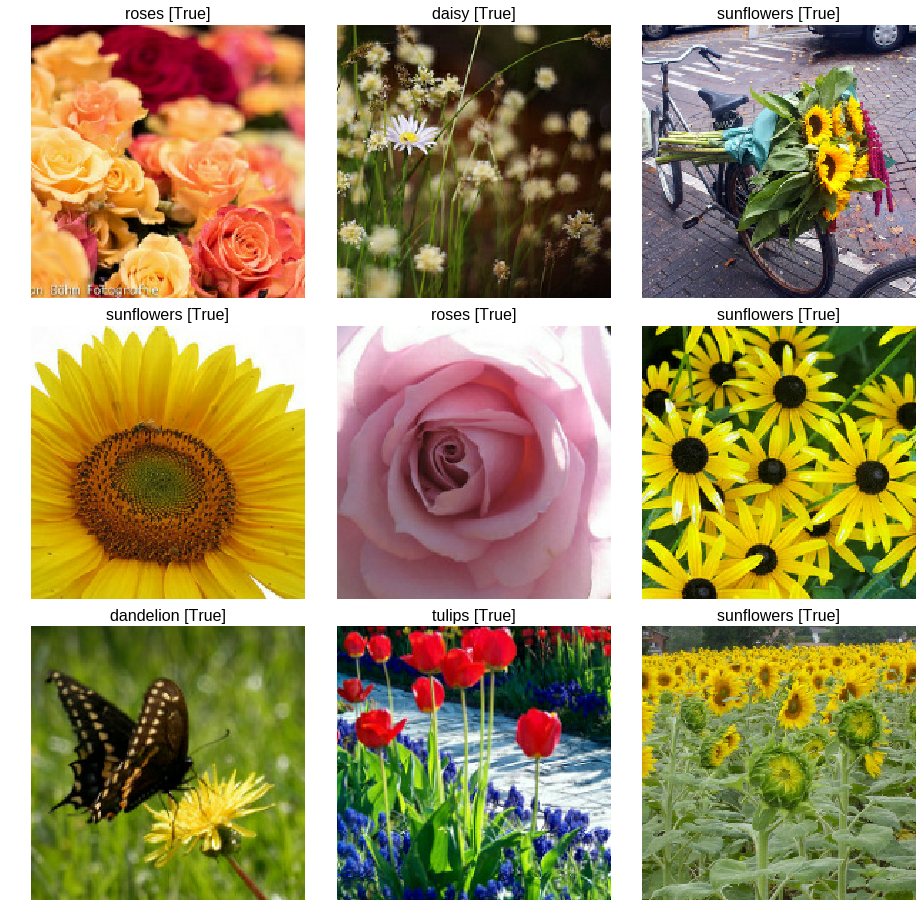

In [15]:
display_9_images_with_predictions(numpy_flowers, probabilities, numpy_labels)